# Image Segmentation and Cell Size Measurement
 

In [9]:
import numpy as np 
import pandas as pd 
import skimage.io 
import skimage.filters
import skimage.color
import scipy.ndimage
import scipy.interpolate
import scipy.signal
import size.viz 
import size.image
import size.analytical
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
import napari
import glob
import imp 
imp.reload(size.image)
cor, pal = size.viz.matplotlib_style()

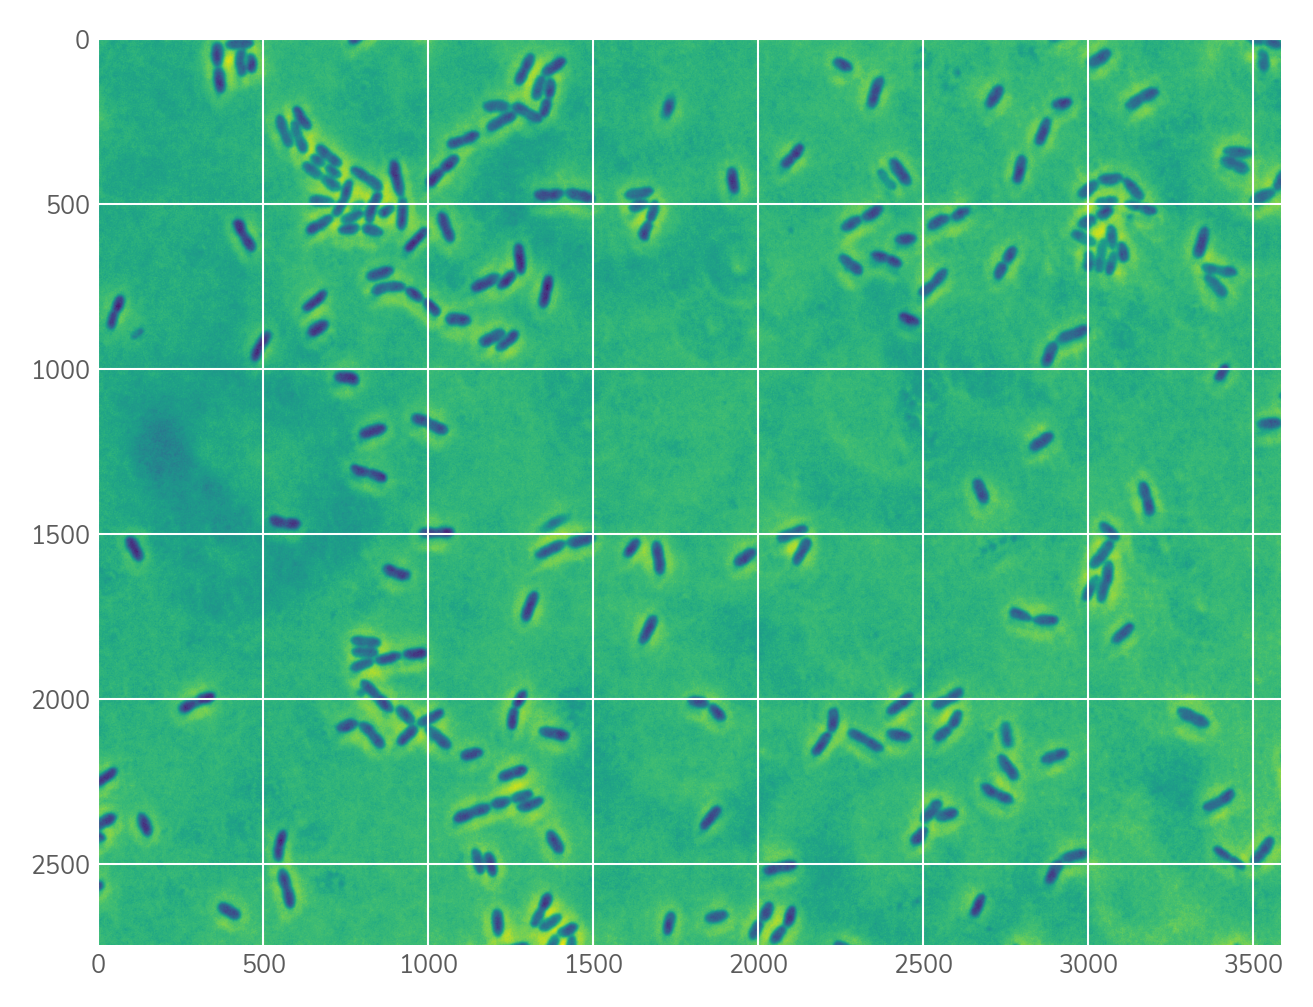

In [2]:
# Load images
files = glob.glob('../../data/images/test/*.tif') 
ims = skimage.io.ImageCollection(files)
test_im = skimage.color.rgb2gray(ims[-1])
crop = test_im#[1800:3000, 1800:]
crop = (crop - crop.min()) / (crop.max() - crop.min())
plt.imshow(crop)

In [3]:
print('Segmenting')
cells, mask = size.image.contour_segmentation(crop, return_mask=True)
print("Assigning anatomy")
anatomy = size.image.assign_anatomy(cells)
print('Acquiring biometrics')
biometrics = size.image.measure_biometrics(anatomy)

Segmenting


  0%|          | 0/133 [00:00<?, ?it/s]/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][193]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][193]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][151]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][236]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][236]=x[1][0]
  warnings.warn(Runtime

Assigning anatomy
Acquiring biometrics


KeyError: False

In [12]:
sizes = size.image.measure_biometrics(anatomy)

(array([4., 2., 3., 0., 4., 4., 4., 8., 3., 4., 3., 5., 4., 2., 4., 3., 5.,
        3., 3., 1., 1., 0., 1., 0., 1.]),
 array([0.93737571, 0.97986633, 1.02235694, 1.06484756, 1.10733817,
        1.14982879, 1.19231941, 1.23481002, 1.27730064, 1.31979125,
        1.36228187, 1.40477249, 1.4472631 , 1.48975372, 1.53224434,
        1.57473495, 1.61722557, 1.65971618, 1.7022068 , 1.74469742,
        1.78718803, 1.82967865, 1.87216926, 1.91465988, 1.9571505 ,
        1.99964111]),
 <BarContainer object of 25 artists>)

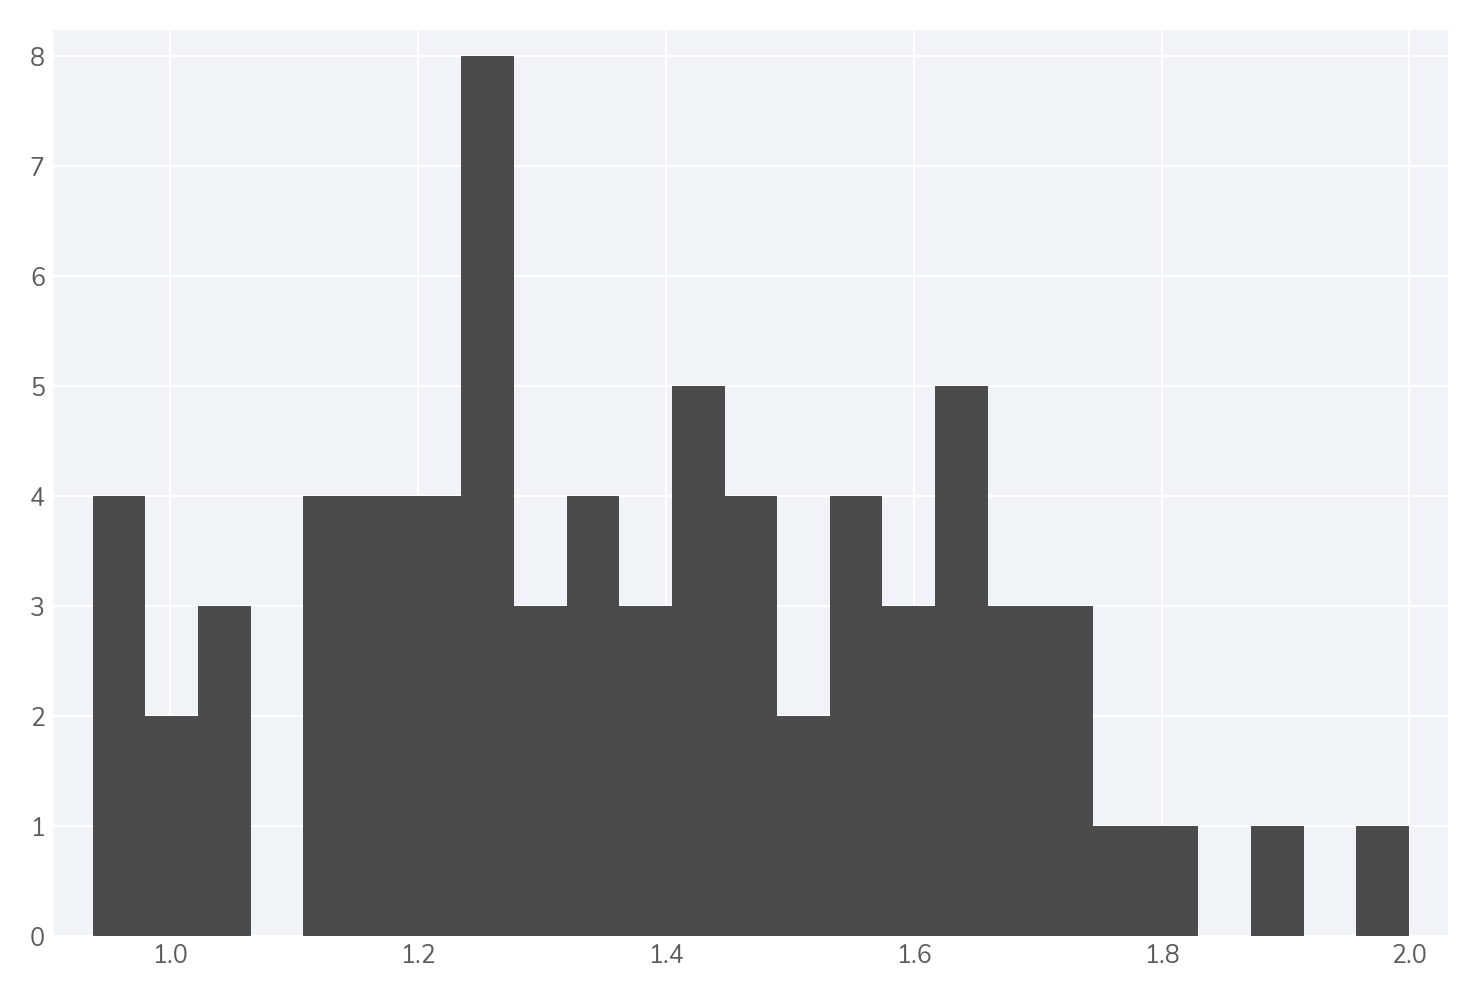

In [14]:
plt.hist(sizes['length'], bins=25)

In [5]:
cells

,x_coords,y_coords,curvature,cell_id
0,26.130342,87.084965,0.075906,0
1,26.111840,87.084428,0.075919,0
2,26.093339,87.083866,0.075931,0
3,26.074841,87.083278,0.075944,0
4,26.056345,87.082664,0.075956,0
...,...,...,...,...
9994,27.627055,79.981740,0.123732,71
9995,27.613428,79.983122,0.123753,71
9996,27.599798,79.984481,0.123774,71
9997,27.586168,79.985817,0.123793,71


## Exploratory below

In [249]:
# # Normalize the image.
im_blur = skimage.filters.gaussian(crop, 30)
im_sub = crop - im_blur
lg_selem = skimage.morphology.disk(50)
sm_selem = skimage.morphology.disk(2)
blk_tophat = skimage.morphology.black_tophat(im_sub, lg_selem)
wht_tophat = skimage.morphology.white_tophat(blk_tophat, lg_selem)
closing = scipy.ndimage.grey_closing(wht_tophat, footprint=sm_selem)
plt.imshow(closing)

KeyboardInterrupt: 

In [250]:

thresh = skimage.filters.threshold_otsu(closing)

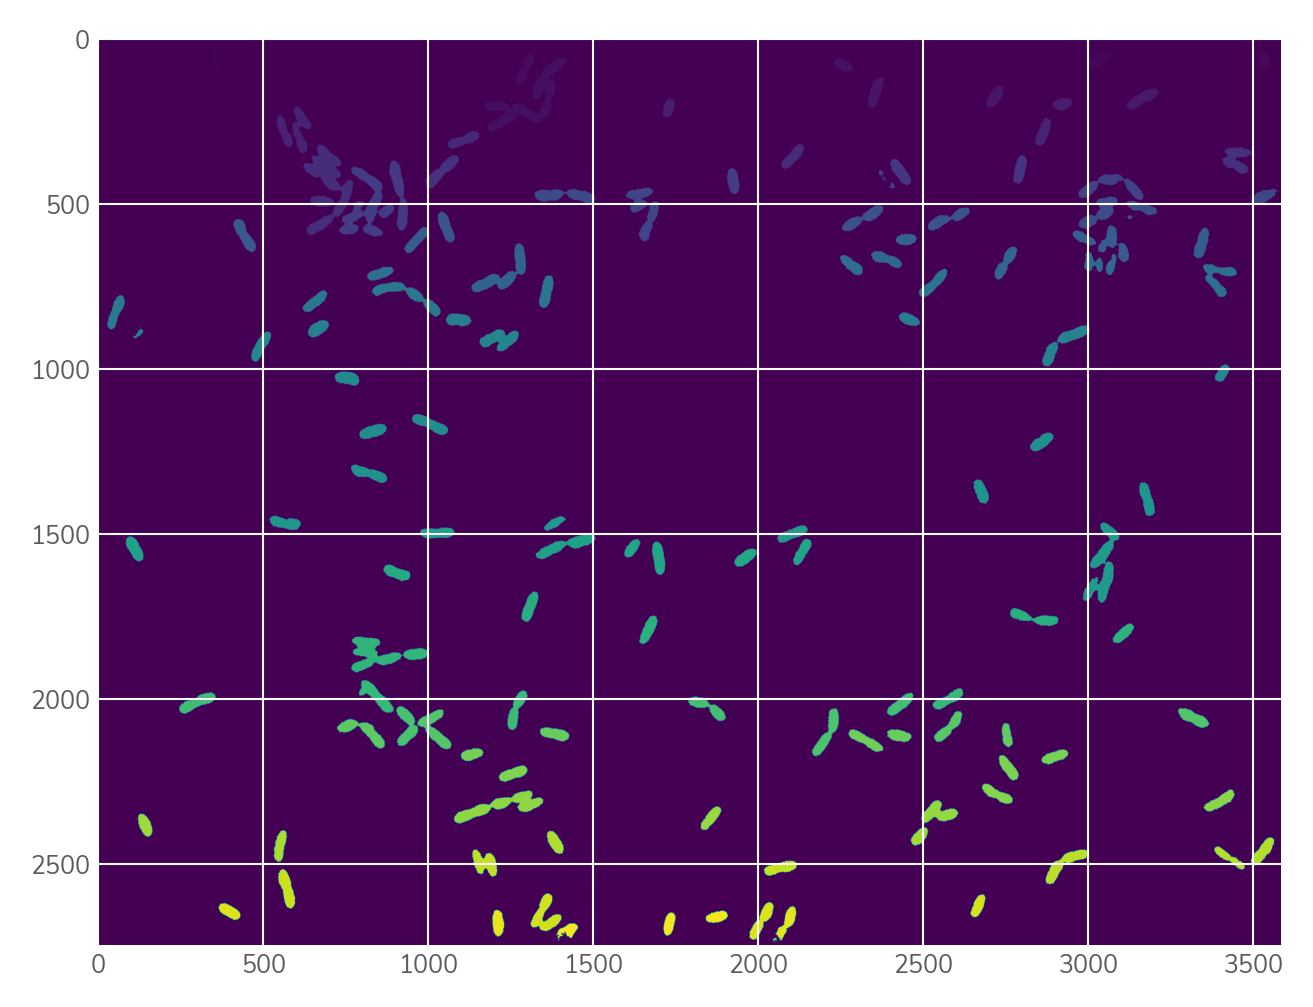

In [251]:
diff = (closing > thresh) * closing
selem = skimage.morphology.square(2)
dilation_selem = skimage.morphology.disk(4) 
seg = size.image.log_segmentation(diff, radius=1, selem=selem, 
                                  thresh=0.001, median_filt=False, 
                                  label=False)
seg = skimage.morphology.binary_erosion(seg, selem)
seg = skimage.morphology.remove_small_holes(seg)
seg = skimage.morphology.remove_small_objects(seg)
labeled = skimage.measure.label(seg)
plt.imshow(labeled)

In [504]:

objs = np.zeros_like(crop)
props = skimage.measure.regionprops(labeled)
obj_ids = []
bboxes = []
cells = []
contours = pd.DataFrame([])
idx = 0
pad = 10 
for p in tqdm.tqdm(props):
    if ((p.area > 1E3) & (p.area < 5E3))  & (p.solidity > 0.9) & (p.eccentricity > 0.5):
        k = labeled==p.label
        objs += k
        obj_ids.append(p.label)
        padded, _ = pad_bbox(p.bbox, np.shape(labeled), pad=10)
        rot = scipy.ndimage.rotate(labeled[padded]==p.label, -np.rad2deg(p.orientation), order=0) > 0
        rot = skimage.morphology.remove_small_holes(rot)
        rot = skimage.morphology.remove_small_objects(rot)
        rot_intensity = scipy.ndimage.rotate(crop[padded], -np.rad2deg(p.orientation),  mode='nearest')
        relab = skimage.measure.label(rot.astype(int))
        rot_props = skimage.measure.regionprops(relab)
        bbox = rot_props[0].bbox
        s, _  = pad_bbox(bbox, np.shape(rot), pad=10)
        cells.append(rot_intensity[s])
        cont = skimage.measure.find_contours(rot[s], 0)[0]
        cx = scipy.ndimage.uniform_filter(cont[:, 1], 10, mode='wrap')
        cy = scipy.ndimage.uniform_filter(cont[:, 0], 10, mode='wrap') 
        tck, u = scipy.interpolate.splprep([cx, cy], per=1, k=5, s=100)
        unew = np.arange(0, 1.0001, 0.0001)
        out = scipy.interpolate.splev(unew, tck)
        out = [list(out[0]), list(out[1])]
        # Perform median filtering
        dx = np.diff(out[0])
        ddx = np.diff(dx)
        dy = np.diff(out[1])
        ddy = np.diff(dy)
        k = (dx[:-1] * ddy  - dy[:-1] * ddx)/((dx[:-1]**2  + dy[:-1]**2)**(3/2))        
        _df = pd.DataFrame([]) 
        _df['spl_x'] = out[0][:-2]
        _df['spl_y'] = out[1][:-2]
        _df['curvature'] = k
        _df['cell_id'] = idx
        # _df['med_curv'] = med_k
        idx += 1
        contours = pd.concat([contours, _df], sort=False)

  0%|          | 0/133 [00:00<?, ?it/s]/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][193]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][193]=x[1][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][151]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[0][236]=x[0][0]
  warnings.warn(RuntimeWarning('Setting x[%d][%d]=x[%d][0]' %
/Users/gchure/opt/anaconda3/lib/python3.8/site-packages/scipy/interpolate/_fitpack_impl.py:226: RuntimeWarning: Setting x[1][236]=x[1][0]
  warnings.warn(Runtime

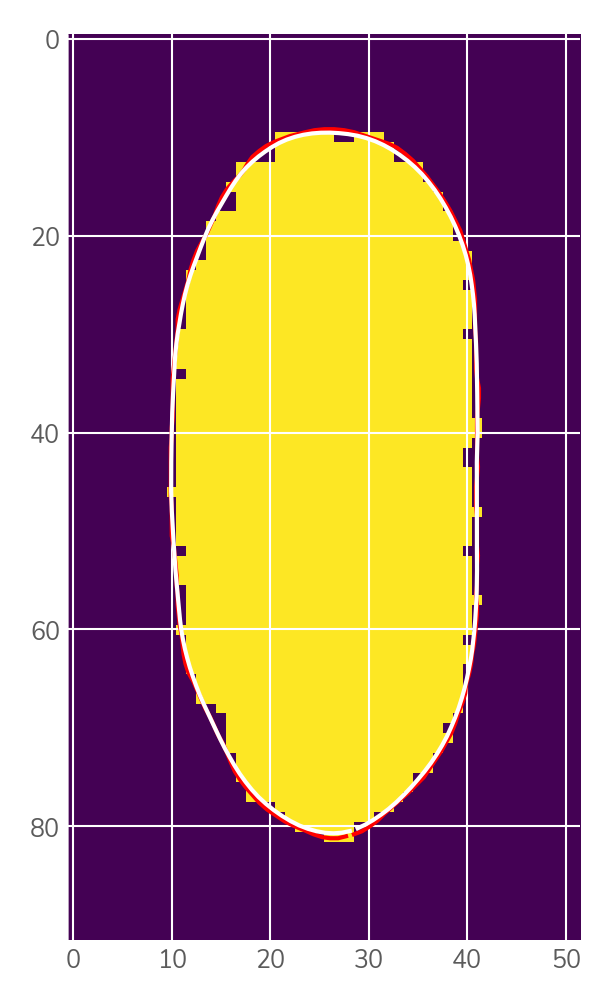

In [505]:
plt.imshow(rot[s])
plt.plot(cx, cy, 'r-', lw=1)
cx_med = scipy.ndimage.uniform_filter(cx, size=10, mode='wrap')
cy_med = scipy.ndimage.uniform_filter(cy, size=10, mode='wrap')
plt.plot(cx_med, cy_med, 'w-', lw=1)

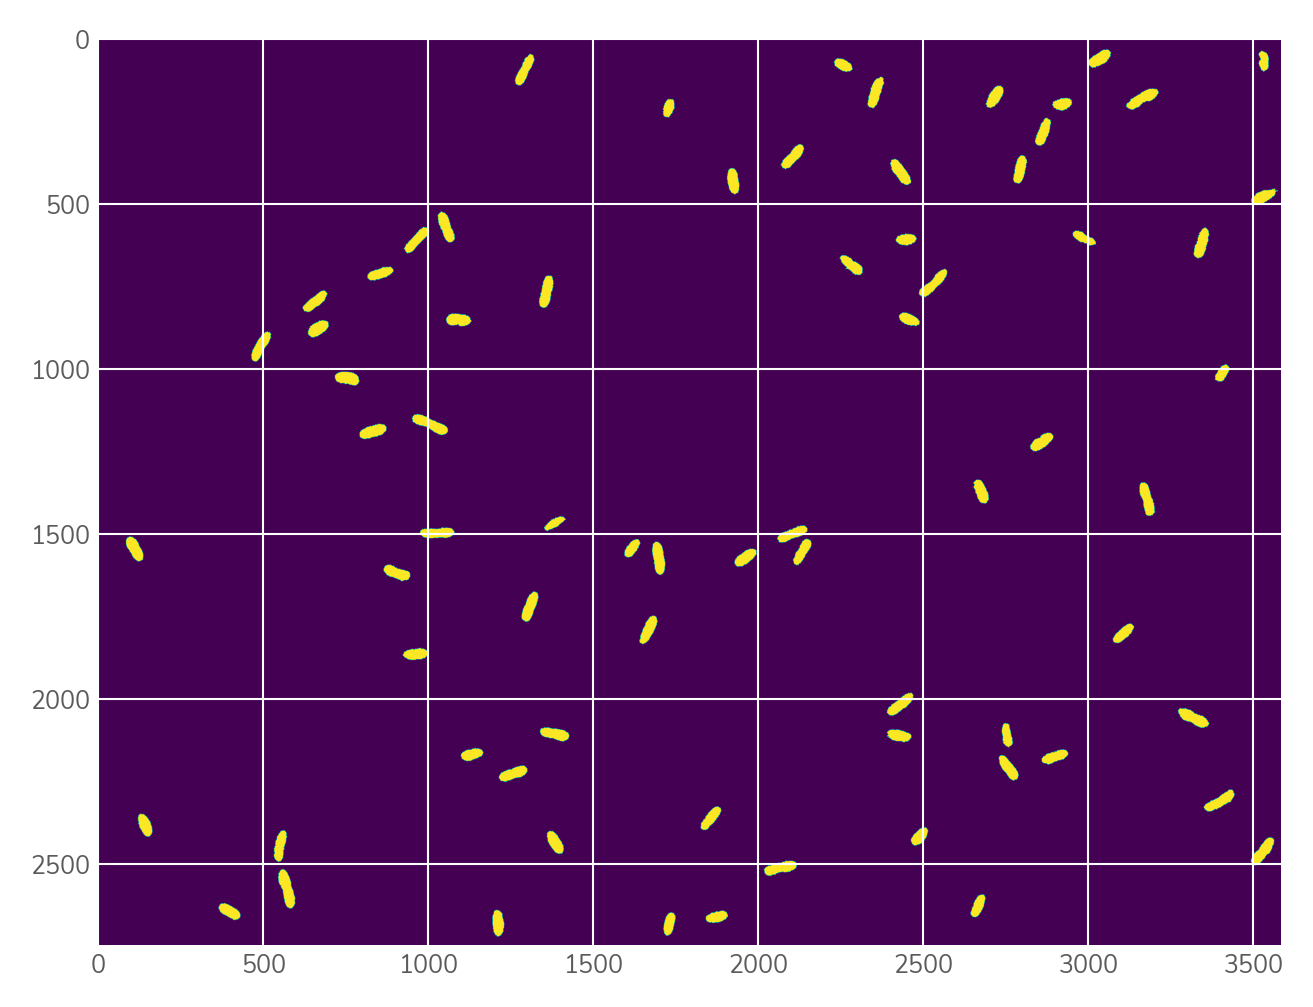

In [506]:
plt.imshow(objs)

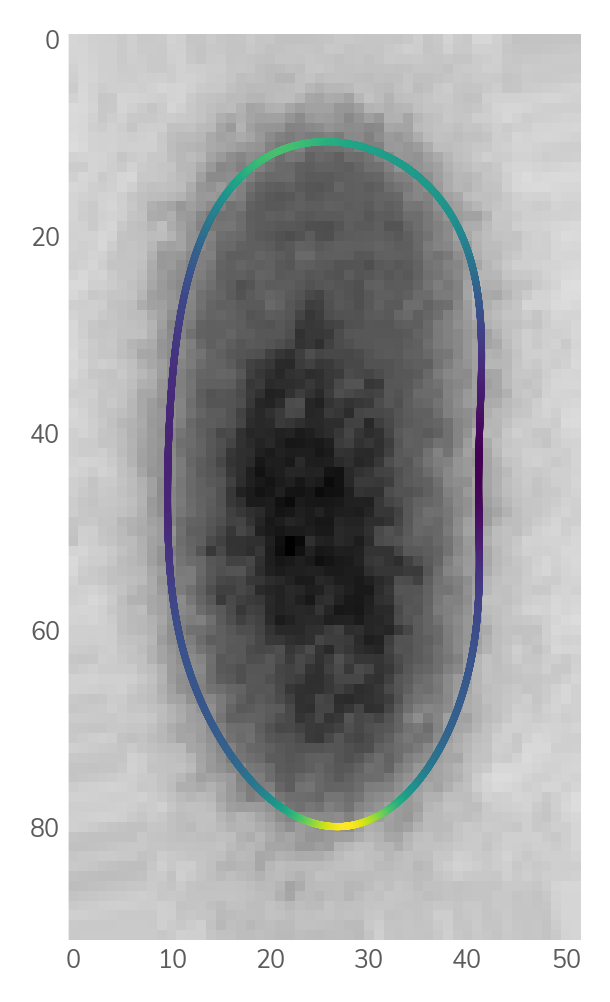

In [507]:
plt.imshow(cells[-1], cmap='Greys_r', vmax=1)
plt.scatter(out[0][:-2], out[1][:-2], c=k, s=2)
plt.grid(False)

Text(0, 0.5, 'length [µm]')

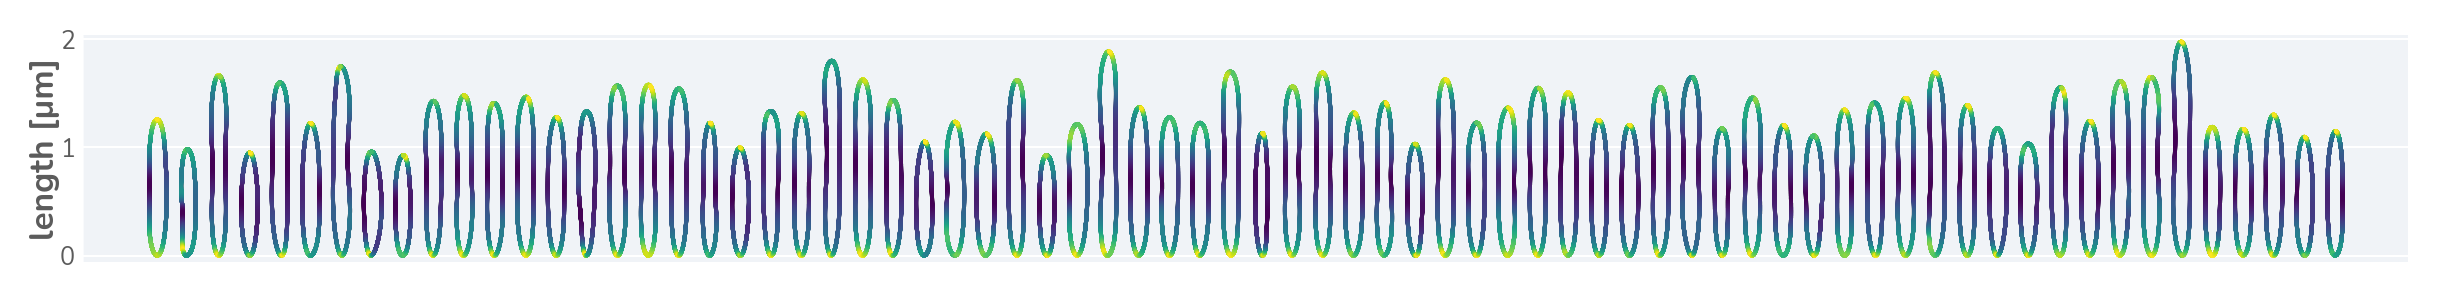

In [508]:
fig, ax = plt.subplots(1,1, figsize=(10, 1))
# ax.axis('equal')
i = 0 
for g, d in contours.groupby('cell_id'):
    ax.scatter((d['spl_x']-d['spl_x'].mean()) + i, (d['spl_y']-d['spl_y'].min()) * 0.0165, c=d['curvature'], s=0.5, alpha=0.5)
    i+= 65
ax.set_xticks([])
ax.set_ylabel('length [µm]')
# plt.savefig('./segmentation_curvature.png')

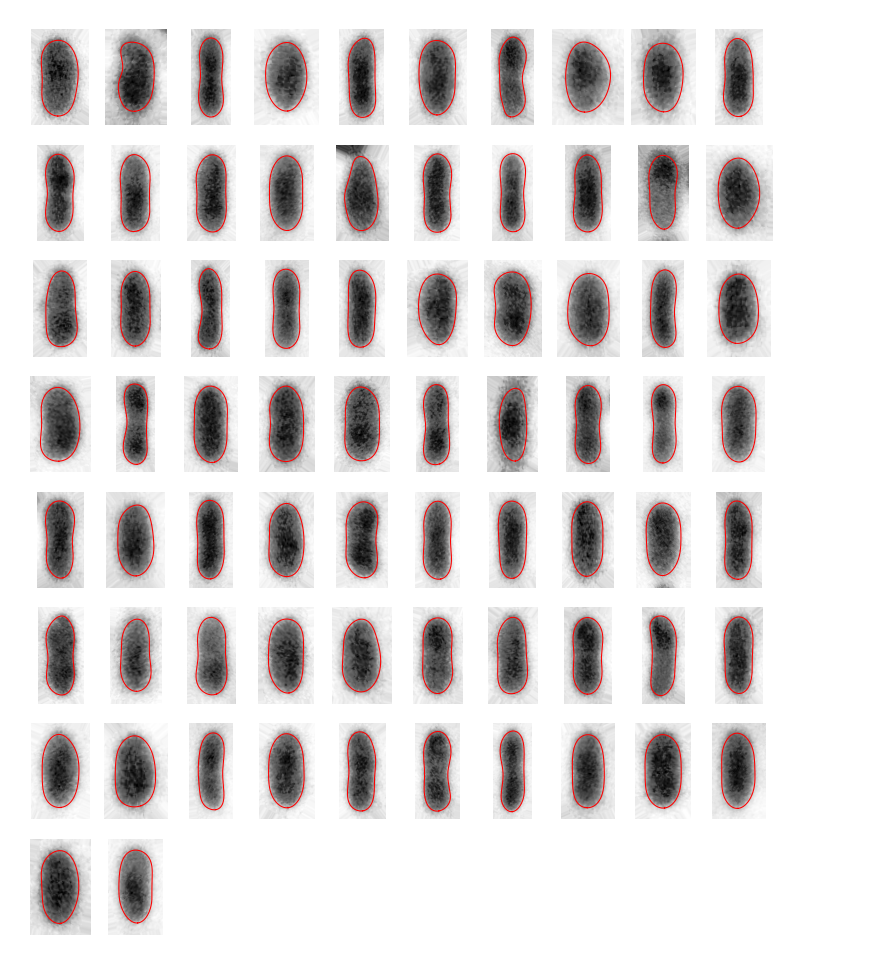

In [509]:
# Determine the number of axes
n_cells = len(cells)
n_cols = 10
n_rows = int(np.ceil(n_cells/n_cols))

fig, ax = plt.subplots(n_rows, n_cols, figsize=(4,4))
ax = ax.ravel()
for a in ax:
    a.axis('off')
for i, c in enumerate(cells):
    ax[i].imshow(c, cmap='Greys_r')
for g, d in contours.groupby('cell_id'):
    ax[g].plot(d['spl_x'], d['spl_y'],color='r', lw=0.25) 
plt.subplots_adjust(wspace=-0.7)
plt.savefig('./segmentation_masks.pdf')

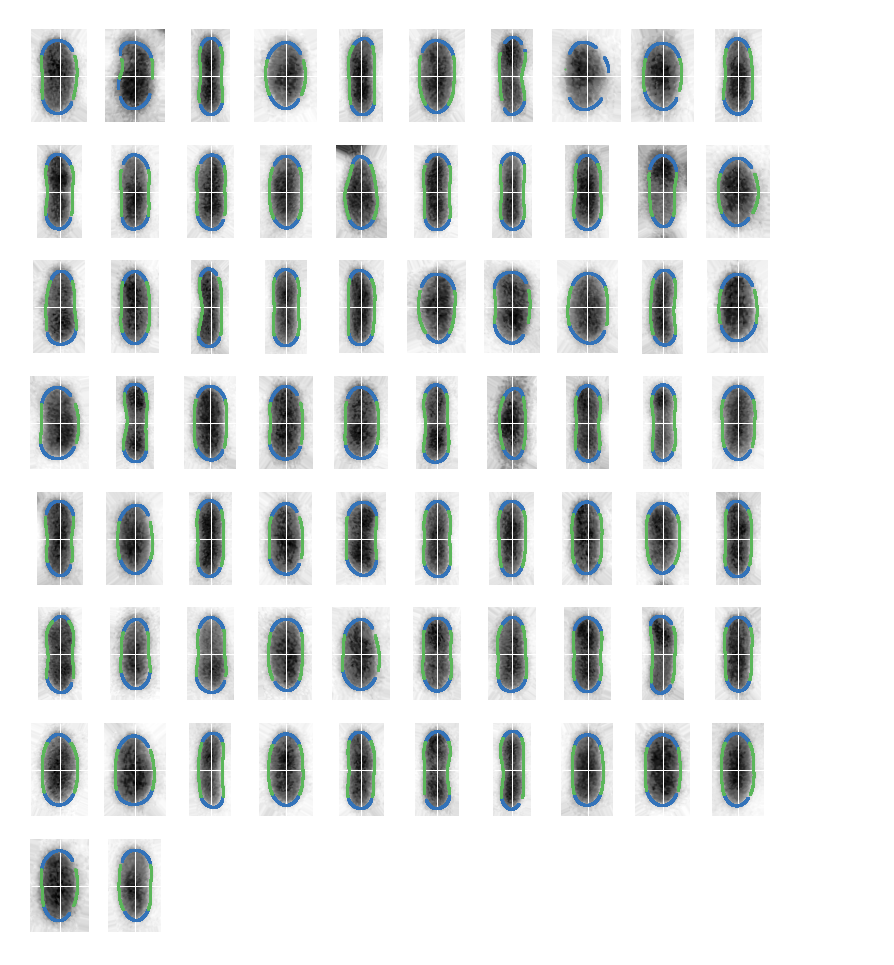

In [514]:
n_cells = len(cells)
n_cols = 10
n_rows = int(np.ceil(n_cells/n_cols))
curve_low = 1/(0.5/0.0167)
fig, ax = plt.subplots(n_rows, n_cols, figsize=(4,4))
ax = ax.ravel()
midplanes = []
for a in ax:
    a.axis('off')
for i, c in enumerate(cells):
    ax[i].imshow(c, cmap='Greys_r')
    cshape = np.shape(c) 
    ax[i].hlines(cshape[0]/2, 0, cshape[1], 'w', linewidth=0.25)
    ax[i].vlines(cshape[1]/2, 0, cshape[0], 'w', linewidth=0.25)
    midplanes.append(cshape[0]/2)
for g, d in contours.groupby('cell_id'):
    # Find the caps
    caps = d[(d['curvature'] >= curve_low)]
    max_x = d['spl_x'].max()
    max_y = d['spl_y'].max()
    # Find the lower cap boundary
    bottom_cap_bound = caps[caps['spl_y'] < (0.5 * max_y)]['spl_y'].max()
    upper_cap_bound = caps[caps['spl_y'] > (0.5 * max_y)]['spl_y'].min()
    sides = d[(d['spl_y'] > bottom_cap_bound) & (d['spl_y'] < upper_cap_bound)]
    # ax[g].plot(sides['spl_x'], sides['spl_y'], '.',color=cor['primary_blue'], ms=1, markeredgewidth=0) 
    ax[g].plot(caps['spl_x'], caps['spl_y'], '.',  color=cor['primary_blue'], ms=1, markeredgewidth=0) 
    ax[g].plot(sides['spl_x'], sides['spl_y'], '.',  color=cor['primary_green'], ms=1, markeredgewidth=0) 
    # ax[g].plot(d['spl_x'][0:1500], d['spl_y'][0:1500], 'w-')
plt.subplots_adjust(wspace=-0.7)
# plt.savefig('./segmentation_masks.pdf')

In [ ]:
def assign_anatomy(data, 
              max_curve=0.5,
              columns = {'groupby' :'cell_id',
                         'curve'   : 'curvature',
                         'x'       : 'spl_x',
                         'y'       : 'spl_y'},
              ip_dist=0.0167 ):

    # Convert supplied curvature threshold to pixel value.
    curve_thresh = ip_dist/max_curve

    df = pd.DataFrame([])  
    for g, d in data.groupby(columns['groupby']):
        # Find the caps
        d = d.copy()
        caps = d[(d[columns['curve']] >= curve_low)].copy()
        max_y = d[columns['y']].max()
        
        # Determine contour points the cell planes
        bottom_cap_bound = caps[(caps[columns['y']] - caps[columns['y']].mean() ) < 0 ][columns['y']].max()
        upper_cap_bound = caps[(caps[columns['y']] - caps[columns['y']].mean() ) > 0 ][columns['y']].min()

        # Label caps as top and bottom
        caps['component'] = 'bottom'
        caps.loc[d[columns['y'] > bottom_cap_bound], 'component'] = 'top'

        # Find and label edges as left and right
        sides = d[(d[columns['y']] > bottom_cap_bound) & (d[columns['y']] < upper_cap_bound)].copy()
        sides['component'] = 'right'
        sides.loc[(sides[columns['x']] - sides[columns['x']].mean()) < 0, 
                'component'] = 'left'
        df = pd.concat([df, caps, sides], sort=False)
    return df

def measure_biometrics(data,                       
                       peri_width=0.025,
                       ip_dist = 0.0167,
                       columns = {'groupby' :'cell_id',
                                  'curve'   : 'curvature',
                                  'x'       : 'spl_x',
                                  'y'       : 'spl_y',
                                  'component': 'component'}):
    """
    Computes properties of cells with assigned anatomy.  
    """
    #TODO. Better way to calculate this length. maximize distance between sides 
    # connecting poles.
        
    # Compute width properties
    biometrics = pd.DataFrame([])
    for g, d in data.groupby(data[columns['groupby']]):
        # Make measurements
        length = (d[columns['y']].max() - d[columns['y']].min()) * ip_dist
        left = d[columns['component']=='left'][columns['y']].values
        right = d[columns['component']=='right'][columns['x']].values
        width = [np.min(rval - left) * ip_dist for rval in right] 
        width_mean = np.mean(width)
        width_var  = np.var(width)

        # Compute features 
        vol = size.analytical.volume(length, width_mean)
        sa = size.analytical.surface_area(length, width_mean)
        sav = sa / vol
        env_vol = size.analytical.envelope_volume(length, width_mean, peri_width)
        frac_vol = env_vol / vol

        # Assemble dataframe
        _df = pd.DataFrame([])
        _df['length'] = length
        _df['width_mean'] = width_mean
        _df['width_var'] = width_var
        _df['volume'] = vol
        _df['surface_area'] = sa
        _df['surface_to_volume'] = sav
        _df['periplasm_volume'] = env_vol
        _df['periplasm_fractional_volume'] = env_vol / vol
        _df[columns['groupby']] = g
        biometrics = pd.concat([_df, biometrics])
    return biometrics



In [299]:
len(caps['spl_y'])

5070

# Turning it into a function


In [ ]:
def tophat_filter(image, 
                  large_selem_diam=50, 
                  small_selem_diam=2,
                  threshold='otsu'):
    """
    Performs a series of tophat transforms to amplify phase contrast images for 
    segmentation

    Parameters
    ==========
    image : 2d-array
        The phase contrast image to be filtered. 
    large_selem_diam : int
        The diameter of the large disk structuring element used in generating the 
        black tophat transform. Default is 50 pixels.
    small_selem_diam : int
        The diameter of the small disk structuring element used in generating the 
        white tophat transform. Default is 2 pixels.
    threshold: str or float
        Threshold used for rough segmentation of cells. If of type `float`, 
        provided value is used. If `otsu`, Otsu's method is used. if 'none',
        no thresholding is applied.

    Returns 
    ========
    closed_image : 2d-array
        The filtered and thresholded (if desired) image. 
    """

    # Normalize the image. 
    im_norm = (image - image.min()) / (image.max() - image.min())

    # Perform background subtraction to correct of uneven illumination
    im_blur = skimage.filters.gaussian(image, 30)
    im_sub = im_norm - im_blur

    # Define structuring elements
    lg_selem = skimage.morphology.disk(large_selem_diam)
    sm_selem = skimage.morphology.disk(small_selem_diam)

    # Perform filtering and closing operations
    blk_tophat = skimage.morphology.black_tophat(im_sub, lg_selem)
    wht_tophat = skimage.morphology.white_tophat(blk_tophat, lg_selem)
    closing = scipy.ndimage.grey_closing(wht_tophat, footprint=sm_selem)

    if threshold == 'otsu':
        thresh = skimage.filter.threshold_otsu(closing)
    elif threshold == 'none':
        return closing
    else:
        thresh = skimage.filter.threshold_otsu(closing)
    return closing * (closing > thresh)

In [532]:
def contour_segmentation(image, 
                         filter=True,
                         area_bounds=(10, 100),
                         ecc_bound=0.5,
                         solidity_bound=0.9,
                         ip_dist=0.0167,
                         return_mask=False,
                         return_cells=False,
                         **filter_kwargs):
    """
    Segments an image using Laplacian of Gaussian then computes smoothed contours 
    of segmented objects. Contour curvature is also computed. 

    Parameters
    ==========
    image : 2d-array
        The image with dark cells to be segmented. 
    filter : bool
        If True, tophat filters will be applied with the supplied kwargs.
    area_bounds : tuple of positive floats 
        The bounds in 2d-projected cell area between which cells are accepted. 
        This must be in the same units as the interpixel distance. Default is
        between 10 and 100 square microns. 
    ecc_bound : positive_float
        Object eccentricity below which objects should be discarded.
        Default is 0.5
    solidity_bound : positive float
        The solidity below chich objects should be discarded. Solidity is 
        defined as the area fraction of the convex hull that is occupied by 
        the object. Default is 0.9.
    ip_dist : float
        The interpixel distance in the same units as `area_bounds`. Default is 
        0.0167 microns per pixel
        TODO: Give more information.
    return_mask : bool
        If True, a mask of segmented objects is returned.
    return_cells : bool
        If True, a dict is compiled containing the cropped segmentation mask 
        and the cropped intensity image. 

    Returns 
    ========
    objects :  pandas DataFrame
        A pandas DataFrame with information regarding  each successfully 
        segmented object.
    mask : 2d-array of ints
        The object segmentation mask after object filtering.  This is only 
        returned if `return_mask == True`.
    cells : dict of dicts
        A dictionary with each segmentation and intensity image for each cell,
        rotated to be aligned. This is only returned if `return_cells==True`.
    """
    if filter:
        _image = tophat_filter(image, **tophat_kwargs)
    else:
        _image = image
    # Perform the laplacian of gaussian segmentation
    log_selem = skimage.morphology.square(2)
    seg = size.image.log_segmentation(image, radius=1, selem=log_selem, 
                                      thresh=0.001, median_filt=False, 
                                      label=False)
    # Clean up the mask and label
    seg = skimage.morphology.binary_erosion(seg, selem)
    seg = skimage.morphology.remove_small_holes(seg)
    seg = skimage.morphology.remove_small_objects(seg)
    labeled = skimage.measure.label(seg)

    # Compute properties and create storage objects
    mask = np.zeros_like(image)
    props = skimage.measure.regionprops(labeled)
    cell_images = {}
    objects = pd.DataFrame([])

    # Iterate through each segmented object
    idx = 0
    for p in tqdm.tqdm(props):
        if ((p.area >= area_bounds[0]/ip_dist) & (p.area < area_bounds[1]/ip_dist)) &\
            (p.solidity > solidity_bound) & (p.eccentricity > ecc_bound):
            # Update the mask
            mask += labeled==p.label
            # Crop the original object and rotate.
            padded, _ = pad_bbox(p.bbox, np.shape(labeled), pad=10)
            rot = scipy.ndimage.rotate(labeled[padded]==p.label, -np.rad2deg(p.orientation), order=0) > 0
            rot = skimage.morphology.remove_small_holes(rot)
            rot = skimage.morphology.remove_small_objects(rot)
            relab = skimage.measure.label(rot.astype(int))
            if return_cells:
                rot_int = scipy.ndimage.rotate(_image, -np.rad2deg(p.orientation), order=0)
                rot_props = skimage.measure.regionprops(relab, intensity_image=rot_int)
            else:
                rot_props = skimage.measure.regionprops(relab)
            bbox = rot_props[0].bbox
            rot_pad, _ = pad_bbox(bbox, np.shape(rot), pad=10)
            
            # If an intensity image is desired, also rotate
            if return_cells:
                rot_intensity = scipy.ndimage.rotate(image[padded], -np.rad2deg(p.orientation),  mode='nearest')
                cell_images[idx] = {'intensity_image':rot_intensity[rot_pad],
                                    'segmentation_mask':rot[rot_pad]}                
            # Find contours and perform a uniform filtering of indices
            cont = skimage.measure.find_contours(rot[rot_pad], 0)[0]
            cx = scipy.ndimage.uniform_filter(cont[:, 1], 10, mode='wrap')
            cy = scipy.ndimage.uniform_filter(cont[:, 0], 10, mode='wrap')  

            # Compute the spline.
            tck, u = scipy.interpolate.splprep([cx, cy], per=1, k=5, s=100)
            unew = np.arange(0, 1.0001, 0.0001)
            out = scipy.interpolate.splev(unew, tck)

            # Compute the curvature and assemble the dataframe
            k = compute_curvature(out)
            _df = pd.DataFrame([]) 
            _df['x_coords'] = out[0][:-2]
            _df['y_coords'] = out[1][:-2]
            _df['curvature'] = k
            _df['cell_id'] = idx
            _df.dropna(inplace=True)
            objects = pd.concat([objects, _df], sort=False)
            # Update the cell counter
            idx += 1
            
    # Determine what needs to be returned
    out = [objects]
    if return_mask:
        out.append(mask)
    if return_cells:
        out.append(cells)
    if len(out) == 1:
        out = out[0]
    return out
    

In [453]:
def pad_bbox(bbox, dims, pad=10):
    """
    Compute a slice object that pads a bounding box. 

    Parameters
    ==========
    bbox : tuple
        The coordinates of the bounding box `(min_row, min_col, max_row, max_col)`.
    dims : tuple
        The dimensions of the original image to avoid overshoot of new bounding 
        box
    pad : int
        The number of pixels to add to each side of the bounding box. Default 
        is 10 pixels.
    
    Returns
    =======
    bbox_new :  (numpy slice object, padded_bbox)
        New bbox as a tuple of a slice index and new bbox coordinates)
    """
    x_lower = [bbox[0]-pad if (bbox[0] - pad) >= 0 else bbox[0]][0] 
    x_upper = [bbox[2]+pad if (bbox[2] + pad) <= dims[0]  else bbox[2]][0]
    y_lower = [bbox[1]-pad if (bbox[1] - pad) >= 0 else bbox[1]][0]
    y_upper = [bbox[3]+pad if (bbox[3] + pad) <= dims[1]  else bbox[3]][0]
    padded_bbox = (x_lower, y_lower, x_upper, y_upper)
    return [np.s_[x_lower:x_upper, y_lower:y_upper], padded_bbox]

In [526]:
def compute_curvature(arr):
    # Pad the entry of each array to allow for boundary conditions
    dx = np.diff(arr[0])
    ddx = np.diff(dx)
    dy = np.diff(arr[1])
    ddy = np.diff(dy)
    k = (dx[:-1] * ddy  - dy[:-1] * ddx)/((dx[:-1]**2  + dy[:-1]**2)**(3/2))     
    return k

In [401]:
np.s_[10:10, 10:10]

(slice(10, 10, None), slice(10, 10, None))

In [407]:
pad_bbox(bbox, np.shape(rot), pad=10)

[(slice(446, 542, None), slice(1665, 1722, None)), (446, 1665, 542, 1722)]